# Data Merging

In [1]:
import pandas as pd

In [2]:
main = pd.read_csv("/kaggle/input/malicious-urls-dataset/malicious_phish.csv")
main

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [3]:
# Define a list of file paths and corresponding types
file_paths = [
    ("/kaggle/input/helper-data/FinalDataset/URL/Benign_list_big_final.csv", "benign"),
    ("/kaggle/input/helper-data/FinalDataset/URL/DefacementSitesURLFiltered.csv", "defacement"),
    ("/kaggle/input/helper-data/FinalDataset/URL/Malware_dataset.csv", "malware"),
    ("/kaggle/input/helper-data/FinalDataset/URL/phishing_dataset.csv", "phishing"),
    ("/kaggle/input/helper-data/FinalDataset/URL/spam_dataset.csv", "spam")
]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the file paths and types
for file_path, url_type in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Assign column names
    df.columns = ["url"]
    # Add a column for the URL type
    df["type"] = url_type
    # Append the dataframe to the list
    dfs.append(df)

dfs.append(main)
# Concatenate the list of dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Display the merged dataframe
merged_df.head(100000)

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
99995,http://www.ccent.com.au/index.php?view=article...,defacement
99996,http://www.ccent.com.au/index.php?option=com_c...,defacement
99997,http://www.ccent.com.au/index.php?option=com_m...,defacement
99998,http://www.ccent.com.au/index.php?view=article...,defacement


In [4]:
print(f"Total rows in merged_df: {merged_df.shape[0]}")

Total rows in merged_df: 653046


# Checking Missing Values

In [5]:
# Check for missing values in merged_df
missing_values = merged_df.isnull().sum()
print(missing_values)

url     0
type    0
dtype: int64


# Data Cleaning

## Checking for Duplicates

In [6]:
# Check for duplicate rows
duplicate_rows = merged_df[merged_df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows)  # Display duplicate rows if any

Number of duplicate rows: 0
Empty DataFrame
Columns: [url, type]
Index: []


In [7]:
# Check for duplicates based on 'url' and 'type' columns
duplicate_rows = merged_df[merged_df.duplicated(subset=['url', 'type'])]
print(f"Number of duplicate rows based on 'url' and 'type': {duplicate_rows.shape[0]}")
print(duplicate_rows)

Number of duplicate rows based on 'url' and 'type': 0
Empty DataFrame
Columns: [url, type]
Index: []


## Checking Outliers - Since the columns url and type are categorical, outlier detection is not typically relevant. However, you can check for anomalies:

### Checking Outliers - Check for Unusual URL Formats

In [8]:
invalid_urls = merged_df[~merged_df['url'].str.startswith(('http', 'https'))]
print(invalid_urls.shape[0])

463125


### Checking Outliers - Check for Unexpected Values in type

In [9]:
print(merged_df['type'].value_counts())

type
benign        428080
defacement     95308
phishing       94092
malware        23645
spam           11921
Name: count, dtype: int64


# Balancing Dataset

Class Distribution:
 type
benign        428080
defacement     95308
phishing       94092
malware        23645
spam           11921
Name: count, dtype: int64


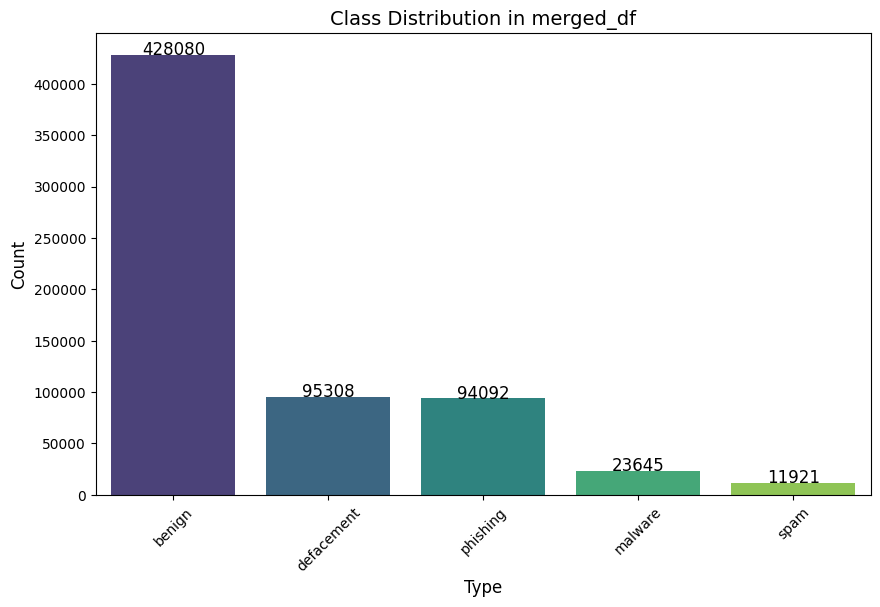

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class in 'type'
class_counts = merged_df['type'].value_counts()

# Print class counts
print("Class Distribution:\n", class_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add text labels on bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=12)

# Customize labels and title
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Class Distribution in merged_df", fontsize=14)
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show the plot
plt.show()

In [11]:
from sklearn.utils import resample

# Step 1: Find the smallest class count
min_count = merged_df['type'].value_counts().min()

# Step 2: Function to undersample each class
def undersample(df, label_col):
    undersampled_dfs = []
    for label in df[label_col].unique():
        temp_df = df[df[label_col] == label]  # Get all rows for this class
        temp_df = resample(temp_df, replace=False, n_samples=min_count, random_state=42)  # Undersample
        undersampled_dfs.append(temp_df)

    return pd.concat(undersampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset

# Step 3: Apply undersampling
merged_df_balanced = undersample(merged_df, 'type')

# Step 4: Check the new class distribution
print(merged_df_balanced['type'].value_counts())

type
malware       11921
phishing      11921
benign        11921
defacement    11921
spam          11921
Name: count, dtype: int64


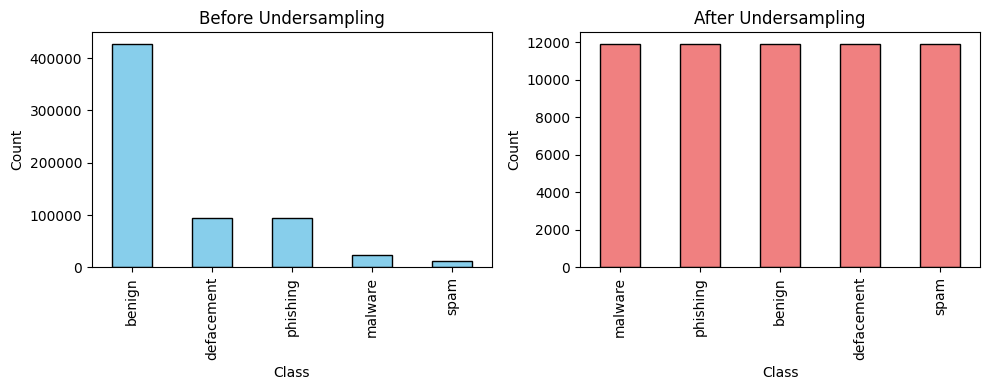

In [12]:
import matplotlib.pyplot as plt

# Plot before undersampling
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
merged_df['type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Before Undersampling")
plt.xlabel("Class")
plt.ylabel("Count")

# Plot after undersampling
plt.subplot(1, 2, 2)
merged_df_balanced['type'].value_counts().plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("After Undersampling")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Encode Categorical Variables

### One-Hot Encoding (For Traditional ML Models)

In [13]:
merged_df1 = pd.get_dummies(merged_df_balanced, columns=['type'], prefix='type')

In [14]:
merged_df1

,url,type_benign,type_defacement,type_malware,type_phishing,type_spam
0,http://118.38.242.167:3647/.i,False,False,True,False,False
1,http://www.mon-remboursement-impots-gouv.drops...,False,False,False,True,False
2,https://mitsui-jyuku.mixh.jp/uploads/65043fvas...,False,False,True,False,False
3,http://pltt21-tg6dldbpqn.bilimelektrik.com/car...,False,False,False,True,False
4,https://apbfiber.com/openme/28320d200d42d3_18d...,False,False,True,False,False
...,...,...,...,...,...,...
59600,http://allgirltogaparty.co.uk/gallery2/main.ph...,False,False,False,False,True
59601,lia.deis.unibo.it/Research/SOMA/,False,False,False,True,False
59602,youtube.com/watch?v=I7RCjlJqOa0,True,False,False,False,False
59603,http://affmj.org/index.php?option=com_mailto&t...,False,True,False,False,False


### Embedding Representation (For LLMs & Deep Learning)

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')
type_embeddings = model.encode(merged_df_balanced['type'].tolist())

# Convert embeddings to a DataFrame and merge with merged_df
embeddings_df = pd.DataFrame(type_embeddings, columns=[f'emb_{i}' for i in range(type_embeddings.shape[1])])
merged_df2 = pd.concat([merged_df_balanced.reset_index(drop=True), embeddings_df], axis=1)

Batches:   0%|          | 0/1863 [00:00<?, ?it/s]

In [16]:
merged_df2

,url,type,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,http://118.38.242.167:3647/.i,malware,-0.105643,0.053186,-0.030285,-0.058583,-0.005353,-0.043707,0.071791,0.038849,...,-0.034115,0.040332,0.003352,-0.076577,0.023769,0.048392,0.027126,-0.006477,0.112189,-0.007128
1,http://www.mon-remboursement-impots-gouv.drops...,phishing,-0.064831,-0.015177,-0.000084,-0.010276,-0.014996,0.012315,0.147890,-0.014841,...,-0.025285,-0.039278,0.019773,0.043567,-0.034725,0.068570,0.070867,-0.057785,0.001915,-0.004228
2,https://mitsui-jyuku.mixh.jp/uploads/65043fvas...,malware,-0.105643,0.053186,-0.030285,-0.058583,-0.005353,-0.043707,0.071791,0.038849,...,-0.034115,0.040332,0.003352,-0.076577,0.023769,0.048392,0.027126,-0.006477,0.112189,-0.007128
3,http://pltt21-tg6dldbpqn.bilimelektrik.com/car...,phishing,-0.064831,-0.015177,-0.000084,-0.010276,-0.014996,0.012315,0.147890,-0.014841,...,-0.025285,-0.039278,0.019773,0.043567,-0.034725,0.068570,0.070867,-0.057785,0.001915,-0.004228
4,https://apbfiber.com/openme/28320d200d42d3_18d...,malware,-0.105643,0.053186,-0.030285,-0.058583,-0.005353,-0.043707,0.071791,0.038849,...,-0.034115,0.040332,0.003352,-0.076577,0.023769,0.048392,0.027126,-0.006477,0.112189,-0.007128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59600,http://allgirltogaparty.co.uk/gallery2/main.ph...,spam,-0.094140,-0.006283,-0.017364,0.082168,-0.008320,-0.032176,0.082705,-0.020973,...,-0.009214,0.026314,0.000600,-0.035779,0.021950,0.067642,0.060077,-0.036059,-0.035207,0.034385
59601,lia.deis.unibo.it/Research/SOMA/,phishing,-0.064831,-0.015177,-0.000084,-0.010276,-0.014996,0.012315,0.147890,-0.014841,...,-0.025285,-0.039278,0.019773,0.043567,-0.034725,0.068570,0.070867,-0.057785,0.001915,-0.004228
59602,youtube.com/watch?v=I7RCjlJqOa0,benign,0.048667,-0.012966,-0.010837,0.059385,-0.008962,-0.083854,0.153233,0.048950,...,-0.022645,-0.014306,0.009236,0.004051,-0.068807,0.022418,0.100677,0.032748,0.062470,0.020058
59603,http://affmj.org/index.php?option=com_mailto&t...,defacement,-0.080718,0.053194,0.095232,0.014358,0.041276,-0.021491,0.120291,-0.070607,...,0.023917,-0.038647,0.025900,0.048007,-0.007449,0.023145,-0.008415,-0.064129,0.076216,-0.012883


# Exploratory Data Analysis (EDA)

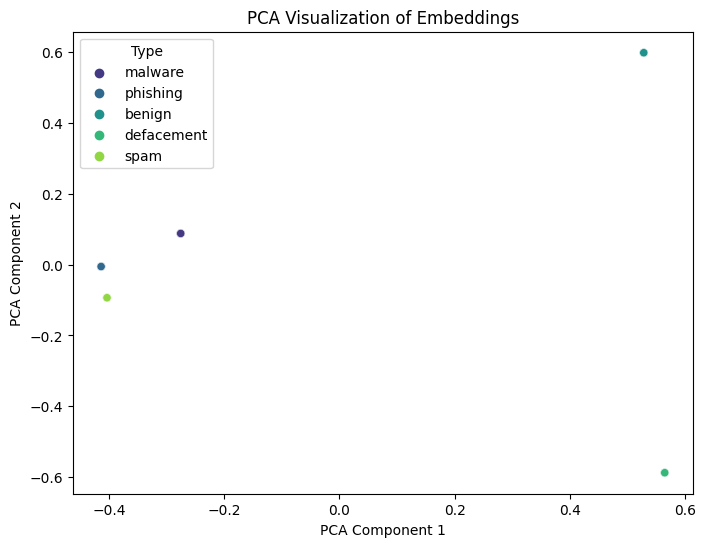

In [17]:
from sklearn.decomposition import PCA
import numpy as np

# Extract embeddings
embedding_columns = [col for col in merged_df2.columns if col.startswith("emb_")]
X_embedded = PCA(n_components=2).fit_transform(merged_df2[embedding_columns])

# Scatter plot of PCA-reduced embeddings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=merged_df2['type'], palette='viridis', alpha=0.7)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Type")
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


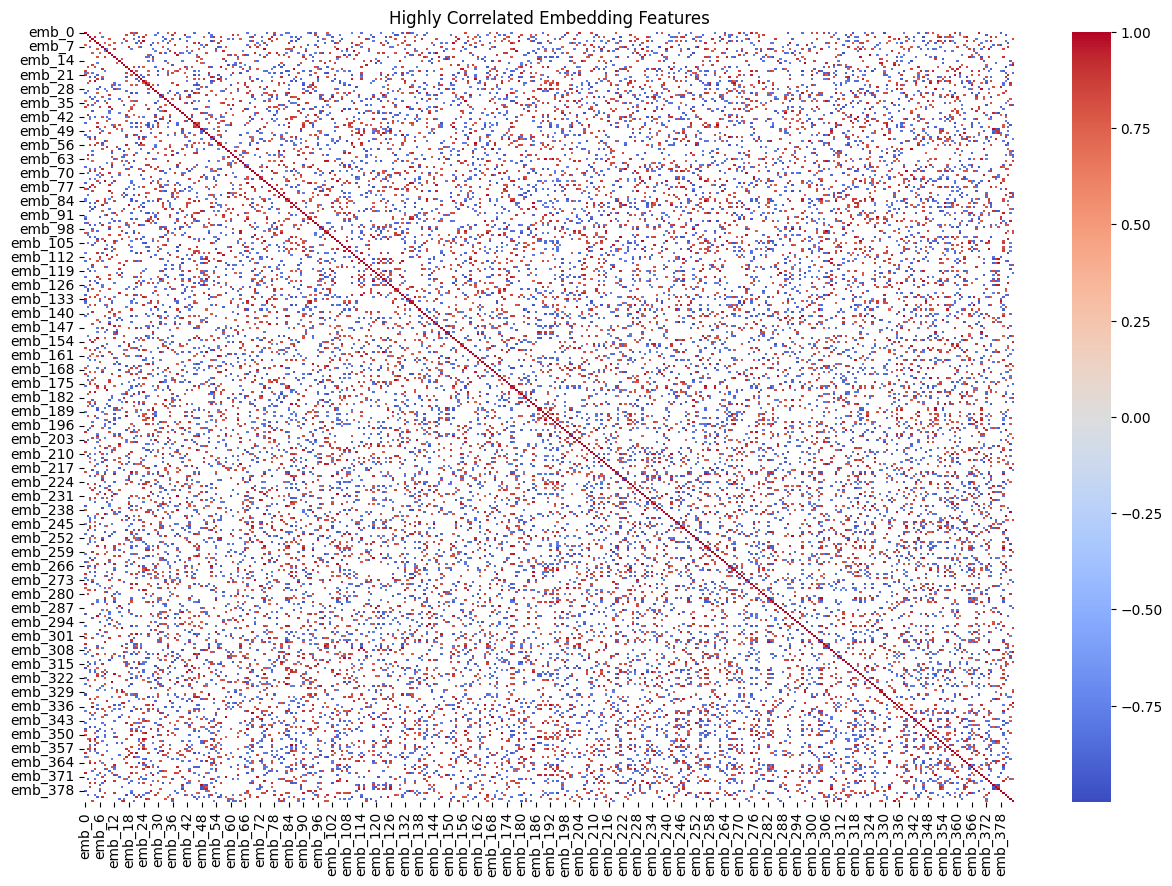

In [18]:
# Compute correlation matrix
corr_matrix = merged_df2.drop(columns=["url", "type"]).corr()

# Select only high correlations (above 0.75 or below -0.75)
high_corr_features = corr_matrix[abs(corr_matrix) > 0.75]

plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_features, cmap="coolwarm", annot=False)
plt.title("Highly Correlated Embedding Features")
plt.show()

In [35]:
# Compute correlation matrix
corr_matrix = merged_df_balanced.drop(columns=["url", "type"]).corr()

# Select only high correlations (above 0.75 or below -0.75)
high_corr_features = corr_matrix[abs(corr_matrix) > 0.75]

plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_features, cmap="coolwarm", annot=False)
plt.title("Highly Correlated Embedding Features")
plt.show()

ValueError: could not convert string to float: '118.38.242.167:3647'

### Extract URL-Based Features

In [20]:
from urllib.parse import urlparse

# Extract URL components
merged_df2['url_length'] = merged_df2['url'].apply(len)  # URL length
merged_df2['domain'] = merged_df2['url'].apply(lambda x: urlparse(x).netloc)  # Extract domain
merged_df2['path'] = merged_df2['url'].apply(lambda x: urlparse(x).path)  # Extract path
merged_df2['query'] = merged_df2['url'].apply(lambda x: urlparse(x).query)  # Extract query string
merged_df2['num_subdomains'] = merged_df2['domain'].apply(lambda x: x.count('.'))  # Count subdomains
merged_df2['num_path_tokens'] = merged_df2['path'].apply(lambda x: len(x.split('/')))  # Count path segments

# Print first few rows to verify extracted features
print(merged_df2[['url', 'domain', 'path', 'query', 'num_subdomains', 'num_path_tokens']].head())


                                                 url  \
0                      http://118.38.242.167:3647/.i   
1  http://www.mon-remboursement-impots-gouv.drops...   
2  https://mitsui-jyuku.mixh.jp/uploads/65043fvas...   
3  http://pltt21-tg6dldbpqn.bilimelektrik.com/car...   
4  https://apbfiber.com/openme/28320d200d42d3_18d...   

                                             domain  \
0                               118.38.242.167:3647   
1  www.mon-remboursement-impots-gouv.dropsagency.fr   
2                              mitsui-jyuku.mixh.jp   
3               pltt21-tg6dldbpqn.bilimelektrik.com   
4                                      apbfiber.com   

                                  path query  num_subdomains  num_path_tokens  
0                                  /.i                     3                2  
1                             /Impots/                     3                3  
2             /uploads/65043fvasea.exe                     2                3  
3           

### Analyze URL Length & Malicious Behavior

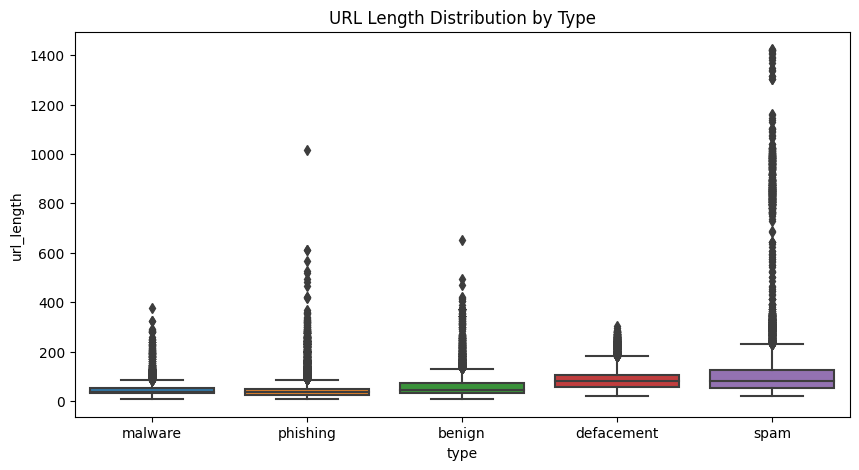

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='type', y='url_length', data=merged_df2)
plt.title("URL Length Distribution by Type")
plt.show()

### Check for Suspicious Tokens

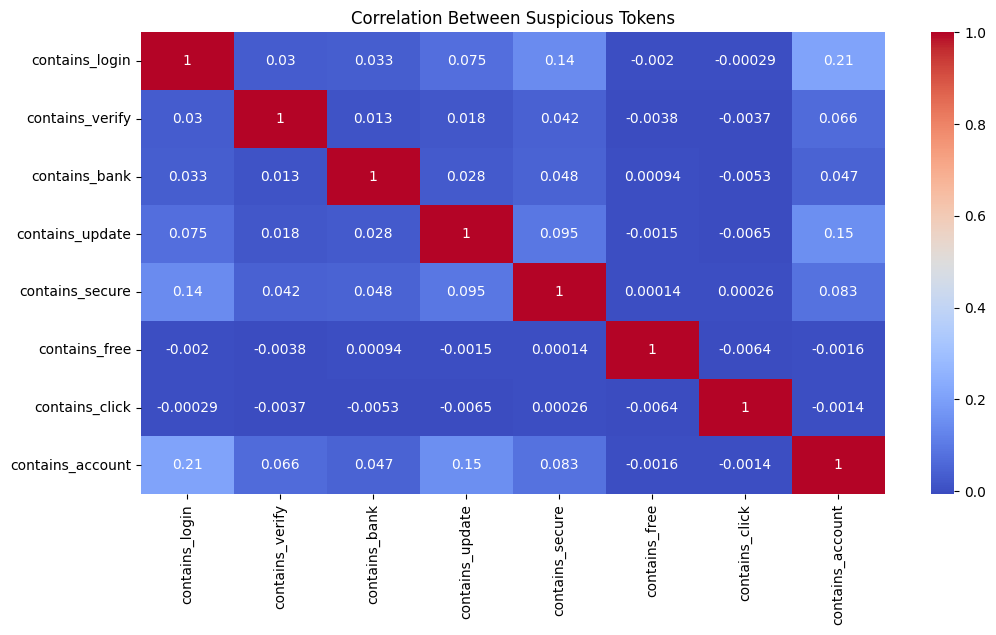

In [22]:
suspicious_tokens = ['login', 'verify', 'bank', 'update', 'secure', 'free', 'click', 'account']

for token in suspicious_tokens:
    merged_df2[f'contains_{token}'] = merged_df2['url'].str.contains(token, case=False, na=False).astype(int)

# Visualize the presence of suspicious tokens
plt.figure(figsize=(12, 6))
sns.heatmap(merged_df2[[f'contains_{token}' for token in suspicious_tokens]].corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Between Suspicious Tokens")
plt.show()

### Special Character Analysis

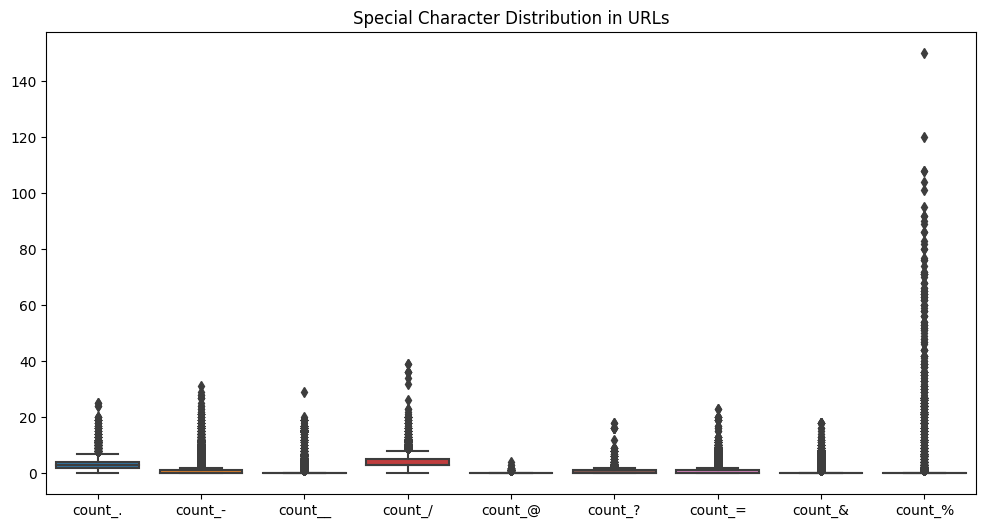

In [23]:
import re

special_chars = ['.', '-', '_', '/', '@', '?', '=', '&', '%']
for char in special_chars:
    merged_df2[f"count_{char}"] = merged_df2["url"].str.count(re.escape(char))

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df2[[f"count_{char}" for char in special_chars]])
plt.title("Special Character Distribution in URLs")
plt.show()

### Domain Popularity Check

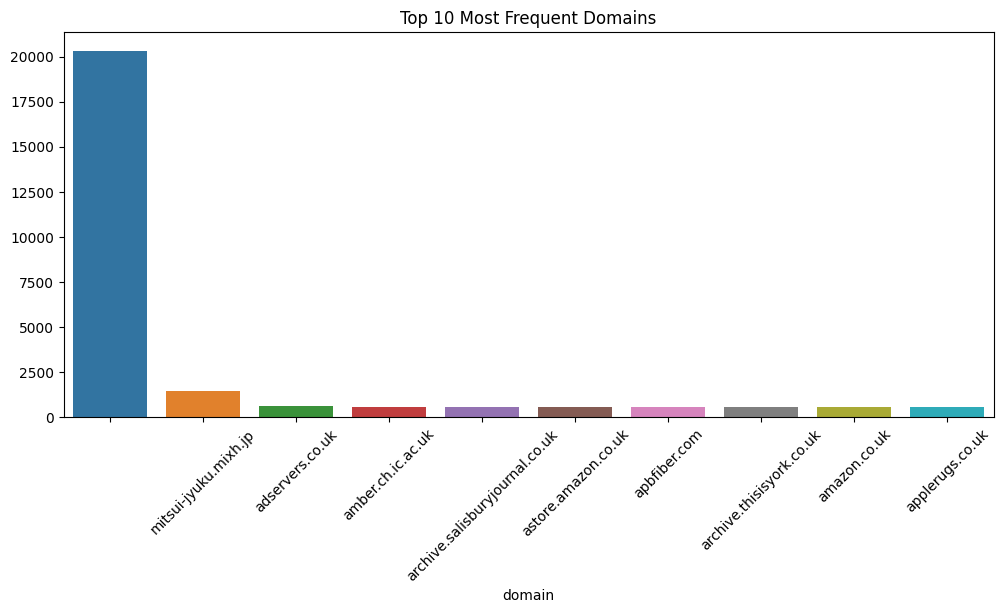

In [24]:
top_domains = merged_df2['domain'].value_counts().nlargest(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_domains.index, y=top_domains.values)
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Domains")
plt.show()


# Graphs and Plots

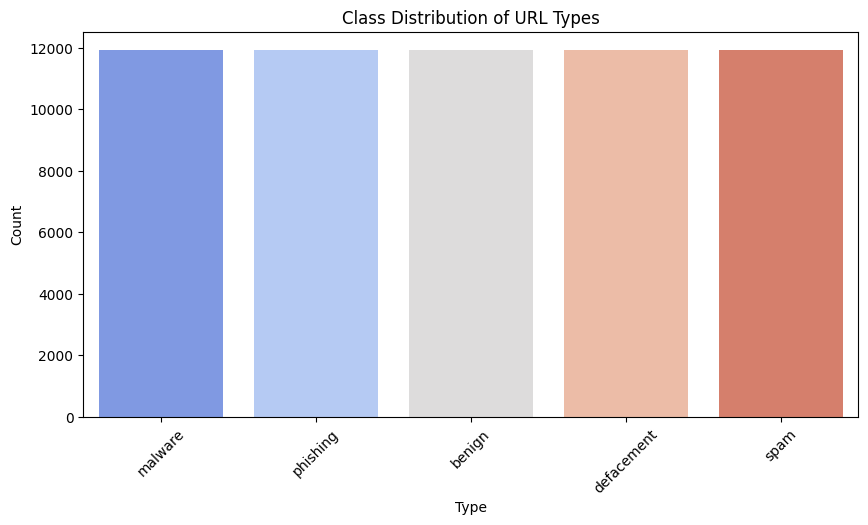

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(x='type', data=merged_df_balanced, order=merged_df_balanced['type'].value_counts().index, palette="coolwarm")
plt.title("Class Distribution of URL Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


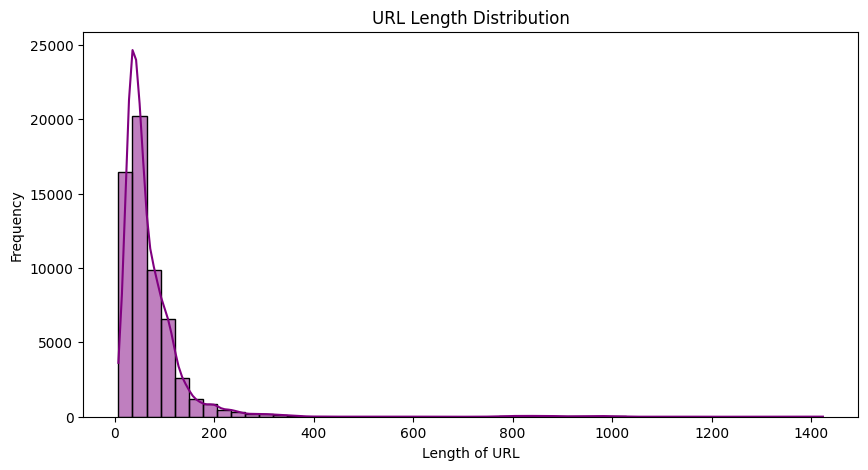

In [26]:
import numpy as np

# Extract URL Length
merged_df_balanced['url_length'] = merged_df_balanced['url'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(merged_df_balanced['url_length'], bins=50, kde=True, color="purple")
plt.title("URL Length Distribution")
plt.xlabel("Length of URL")
plt.ylabel("Frequency")
plt.show()

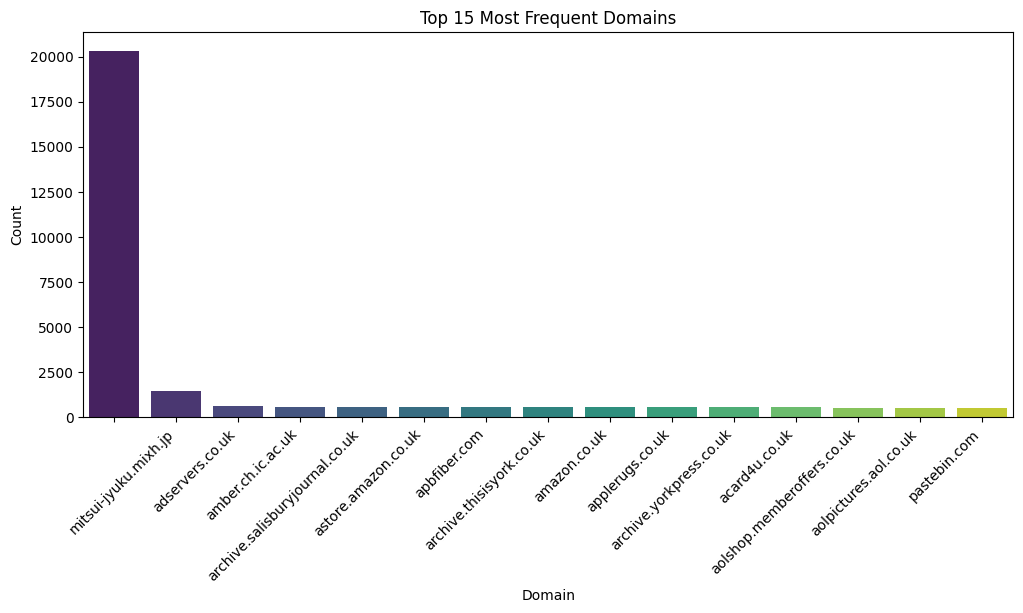

In [27]:
from urllib.parse import urlparse
from collections import Counter

# Extract domain names
merged_df_balanced['domain'] = merged_df_balanced['url'].apply(lambda x: urlparse(x).netloc)

# Get top 15 most common domains
top_domains = merged_df_balanced['domain'].value_counts().nlargest(15)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_domains.index, y=top_domains.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Most Frequent Domains")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.show()


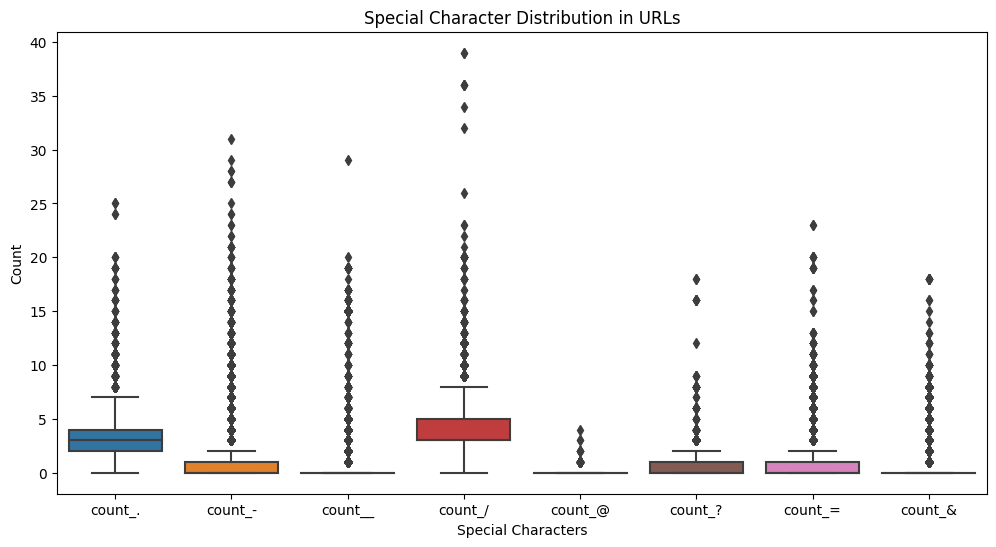

In [28]:
import re

special_chars = ['.', '-', '_', '/', '@', '?', '=', '&']
for char in special_chars:
    merged_df_balanced[f"count_{char}"] = merged_df_balanced["url"].str.count(re.escape(char))

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df_balanced[[f"count_{char}" for char in special_chars]])
plt.title("Special Character Distribution in URLs")
plt.xlabel("Special Characters")
plt.ylabel("Count")
plt.show()

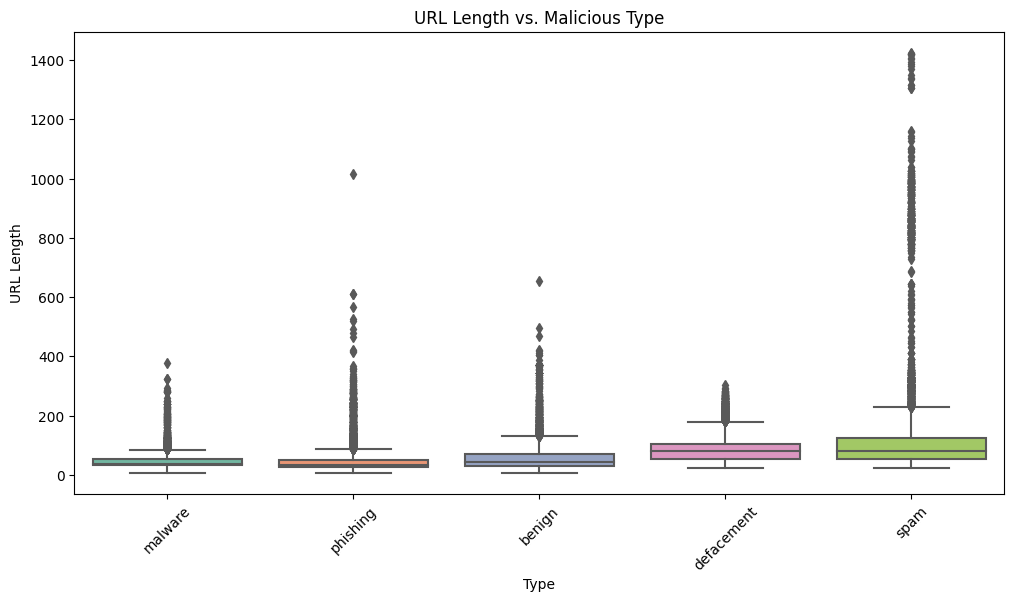

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='url_length', data=merged_df_balanced, palette="Set2")
plt.title("URL Length vs. Malicious Type")
plt.xlabel("Type")
plt.ylabel("URL Length")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

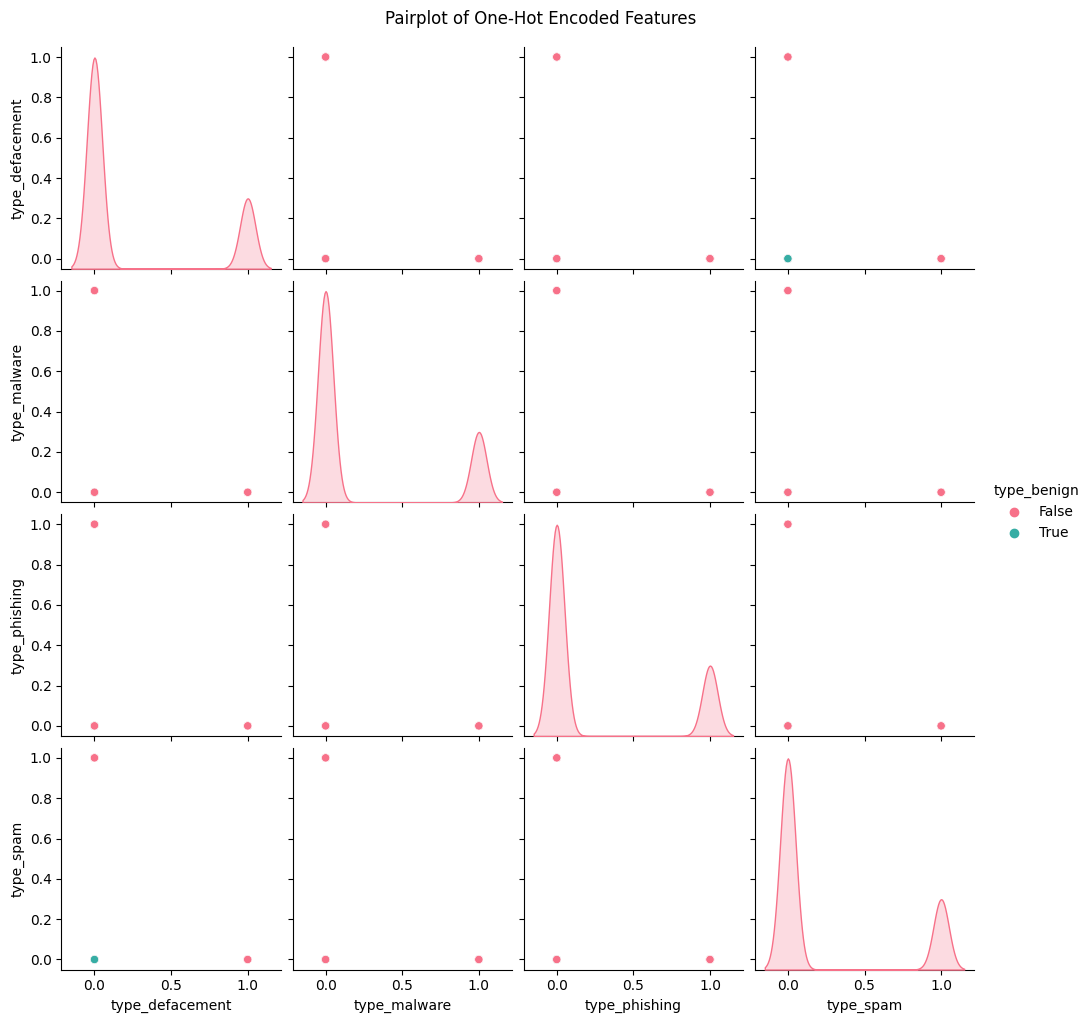

In [30]:
sns.pairplot(merged_df1, hue="type_benign", diag_kind="kde", palette="husl")
plt.suptitle("Pairplot of One-Hot Encoded Features", y=1.02)
plt.show()

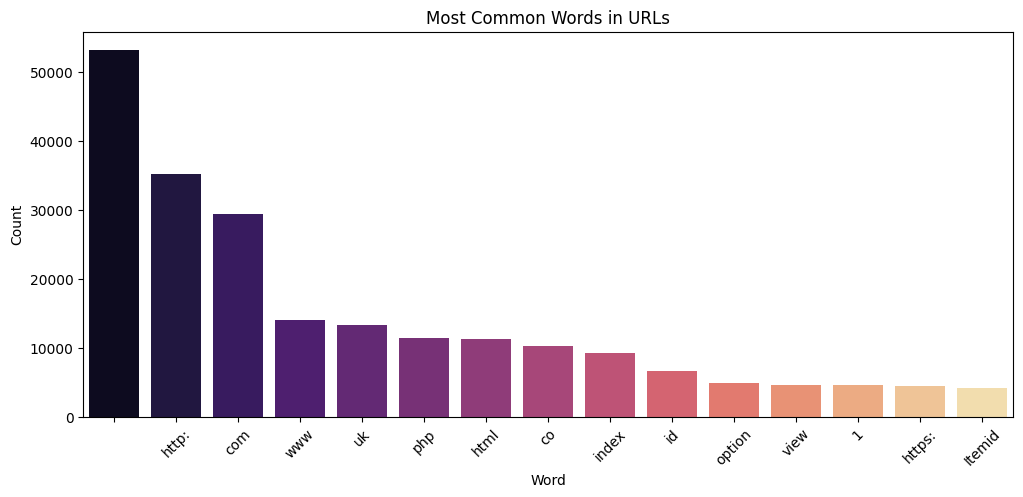

In [31]:
from collections import Counter
import itertools

# Extract words from URLs
word_counts = Counter(itertools.chain.from_iterable(merged_df_balanced['url'].str.split('/|\.|-|_|\?|=|&')))

# Get top 15 most common words
top_words = pd.DataFrame(word_counts.most_common(15), columns=["Word", "Frequency"])

plt.figure(figsize=(12, 5))
sns.barplot(x="Word", y="Frequency", data=top_words, palette="magma")
plt.xticks(rotation=45)
plt.title("Most Common Words in URLs")
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()


In [32]:
from sklearn.decomposition import PCA

# Apply PCA on embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings)

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])
pca_df['type'] = merged_df2['type']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='type', data=pca_df, palette="coolwarm", alpha=0.7)
plt.title("PCA Visualization of URL Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Type")
plt.show()


NameError: name 'X_embeddings' is not defined

<ipython-input-33-8cfb22317ee4>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df_balanced[merged_df_balanced['type'] == label]['url_length'], label=label, shade=True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-33-8cfb22317ee4>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df_balanced[merged_df_balanced['type'] == label]['url_length'], label=label, shade=True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

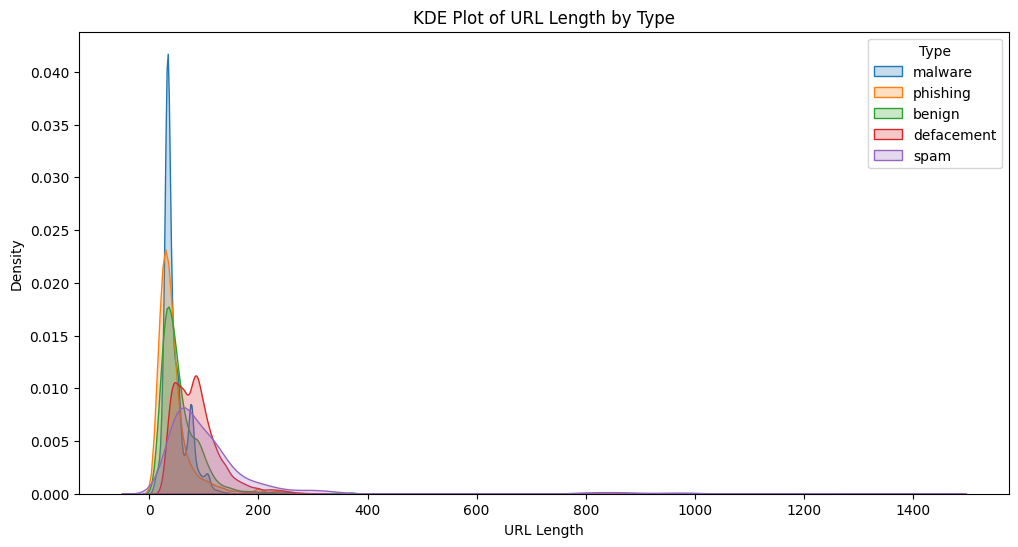

In [33]:
plt.figure(figsize=(12, 6))
for label in merged_df_balanced['type'].unique():
    sns.kdeplot(merged_df_balanced[merged_df_balanced['type'] == label]['url_length'], label=label, shade=True)
plt.title("KDE Plot of URL Length by Type")
plt.xlabel("URL Length")
plt.ylabel("Density")
plt.legend(title="Type")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


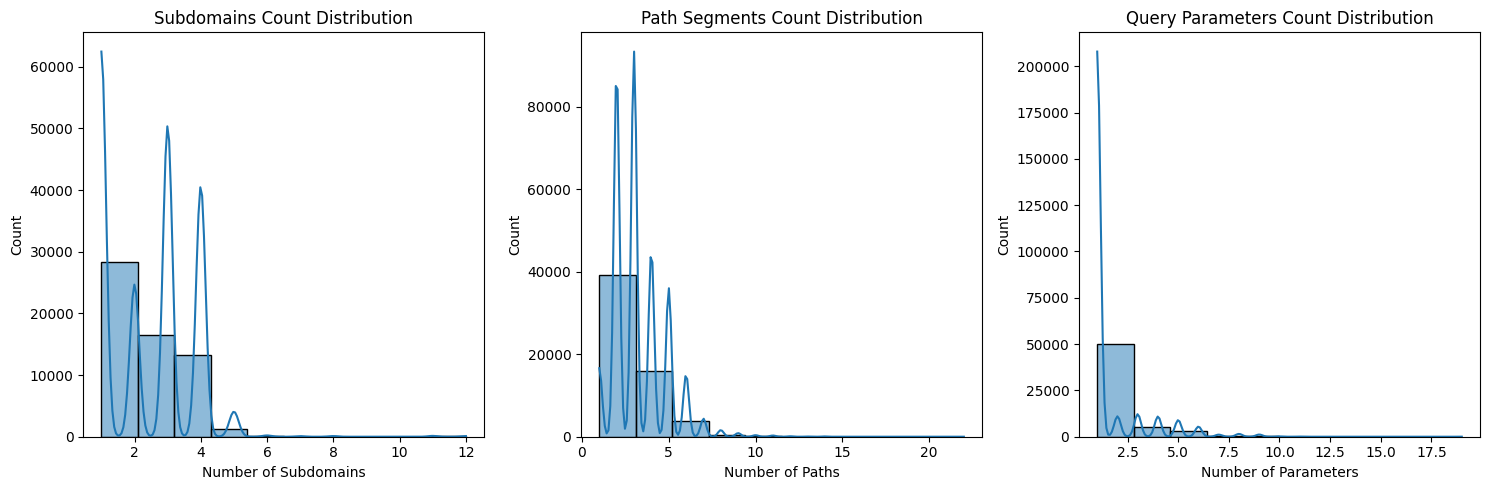

In [34]:
merged_df_balanced["num_subdomains"] = merged_df_balanced["url"].apply(lambda x: len(urlparse(x).netloc.split(".")))
merged_df_balanced["num_paths"] = merged_df_balanced["url"].apply(lambda x: len(urlparse(x).path.split("/")))
merged_df_balanced["num_params"] = merged_df_balanced["url"].apply(lambda x: len(urlparse(x).query.split("&")))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(merged_df_balanced["num_subdomains"], bins=10, kde=True, ax=ax[0])
ax[0].set_title("Subdomains Count Distribution")
ax[0].set_xlabel("Number of Subdomains")

sns.histplot(merged_df_balanced["num_paths"], bins=10, kde=True, ax=ax[1])
ax[1].set_title("Path Segments Count Distribution")
ax[1].set_xlabel("Number of Paths")

sns.histplot(merged_df_balanced["num_params"], bins=10, kde=True, ax=ax[2])
ax[2].set_title("Query Parameters Count Distribution")
ax[2].set_xlabel("Number of Parameters")

plt.tight_layout()
plt.show()


# Feature Extraction

In [36]:
import pandas as pd
import numpy as np
import re
import tldextract
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

# Load dataset
# Assume merged_df_balanced is already loaded

def extract_structural_features(url):
    """Extracts structural features from URLs."""
    features = {}
    features['url_length'] = len(url)
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['num_special_chars'] = len(re.findall(r'[^a-zA-Z0-9]', url))
    features['num_subdomains'] = len(tldextract.extract(url).subdomain.split('.'))
    return features

# Apply feature extraction
structural_features = pd.DataFrame(merged_df_balanced['url'].apply(lambda x: extract_structural_features(x)).tolist())

# TF-IDF Embeddings
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_features = tfidf_vectorizer.fit_transform(merged_df_balanced['url']).toarray()

def tokenize_url(url):
    return re.split(r'[^a-zA-Z]', url.lower())

# Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=merged_df_balanced['url'].apply(tokenize_url), vector_size=100, window=5, min_count=1, workers=4)
def get_w2v_embedding(url):
    words = tokenize_url(url)
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
word2vec_features = np.array(merged_df_balanced['url'].apply(get_w2v_embedding).tolist())

# Character-Level Features
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), max_features=500)
char_features = char_vectorizer.fit_transform(merged_df_balanced['url']).toarray()

# Combine all features
X = np.hstack([structural_features.values, tfidf_features, word2vec_features, char_features])
y = merged_df_balanced['type'].astype('category').cat.codes  # Encode labels

print("Feature extraction completed. Shape:", X.shape)

Feature extraction completed. Shape: (59605, 1104)


# Random Forest

In [37]:
import cupy as cp
import cudf
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convert data to GPU dataframe
X_gpu = cudf.DataFrame(X)
y_gpu = cudf.Series(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)

# Train GPU-based Random Forest Classifier
rf_gpu = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_gpu.fit(X_train, y_train)

# Predictions
y_pred = rf_gpu.predict(X_test)

# Convert to NumPy for evaluation
y_pred_np = y_pred.to_numpy()
y_test_np = y_test.to_numpy()

# Evaluate Model
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"GPU Random Forest Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:363: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


GPU Random Forest Accuracy: 0.9132


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CPU-based Random Forest Classifier
rf_cpu = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_cpu.fit(X_train, y_train)

# Predictions
y_pred = rf_cpu.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"CPU Random Forest Accuracy: {accuracy:.4f}")


CPU Random Forest Accuracy: 0.9124


In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=rf_cpu.classes_, columns=rf_cpu.classes_)

# Display Full Confusion Matrix
print("Confusion Matrix:")
print(cm_df)


Confusion Matrix:
      0     1     2     3     4
0  2219    19    26    98     3
1    15  2354     7     6     1
2    47    86  2147   120     1
3   386   171    52  1728     6
4     0     0     0     0  2429


# LSTM

In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Data

# Tokenization of URLs
max_words = 5000  # Maximum words in the vocabulary
max_len = 100  # Maximum length of each URL sequence

tokenizer = Tokenizer(num_words=max_words, char_level=True)  # Character-level tokenization
tokenizer.fit_on_texts(merged_df_balanced['url'])

# Convert URLs to sequences
X = tokenizer.texts_to_sequences(merged_df_balanced['url'])
X = pad_sequences(X, maxlen=max_len, padding='post')

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_df_balanced['type'])  # Convert labels to numerical values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define LSTM model
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(set(y)), activation='softmax')  # Output layer for multi-class classification
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on GPU if available
with tf.device('/GPU:0'):  # This ensures training runs on GPU
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/5
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.4141 - loss: 1.3109 - val_accuracy: 0.6753 - val_loss: 0.7287
Epoch 2/5
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7033 - loss: 0.6695 - val_accuracy: 0.5939 - val_loss: 0.9208
Epoch 3/5
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7039 - loss: 0.7422 - val_accuracy: 0.8459 - val_loss: 0.4040
Epoch 4/5
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8705 - loss: 0.3699 - val_accuracy: 0.8884 - val_loss: 0.3092
Epoch 5/5
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8854 - loss: 0.3259 - val_accuracy: 0.9031 - val_loss: 0.2782
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9050 - loss: 0.2714
Test Accuracy: 0.9031


559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


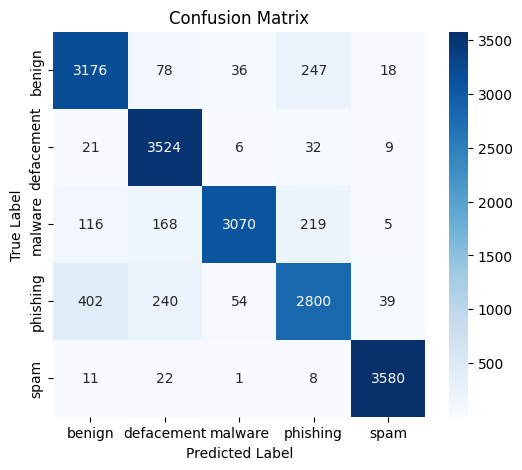

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


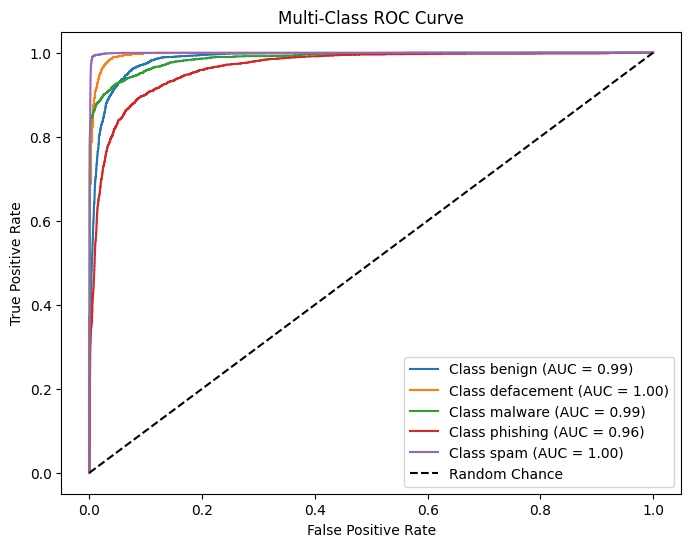

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for ROC-AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(set(y))))
y_pred_bin = y_pred  # Already softmax probabilities

# Plot ROC Curve for each class
plt.figure(figsize=(8,6))
for i in range(len(set(y))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()


# BERT

In [58]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# Load dataset

# Function to extract structural features
def extract_features(url):
    parsed_url = urlparse(url)
    return {
        'url_length': len(url),
        'num_dots': url.count('.'),
        'num_slashes': url.count('/'),
        'num_digits': sum(char.isdigit() for char in url),
        'num_special_chars': len(re.findall(r'[!@#$%^&*(),?":{}|<>]', url)),
        'subdomain_length': len(parsed_url.netloc.split('.')[0]),
        'path_length': len(parsed_url.path)
    }

# Apply feature extraction
structural_features = merged_df_balanced['url'].apply(lambda x: extract_features(x))
structural_df = pd.DataFrame(list(structural_features))

# TF-IDF feature extraction (baseline NLP features)
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(merged_df_balanced['url']).toarray()

# Combine all features
X_structural = np.hstack((structural_df.values, tfidf_features))
y_labels = merged_df_balanced['type']


In [61]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch

# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

# Tokenize URLs
class URLDataset(Dataset):
    def __init__(self, urls, labels):
        self.urls = urls
        self.labels = labels

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        encoded_url = tokenizer(self.urls[idx], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return {
            'input_ids': encoded_url['input_ids'].squeeze(0),
            'attention_mask': encoded_url['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Train-test split
from sklearn.model_selection import train_test_split

urls_train, urls_test, y_train, y_test = train_test_split(merged_df_balanced['url'], y, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = URLDataset(urls_train.tolist(), y_train)
test_dataset = URLDataset(urls_test.tolist(), y_test)

# Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(set(y)))

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=True
)

# Trainer API for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.089300,0.087957


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1491, training_loss=0.18409203299734114, metrics={'train_runtime': 785.0395, 'train_samples_per_second': 60.741, 'train_steps_per_second': 1.899, 'total_flos': 3136631376313344.0, 'train_loss': 0.18409203299734114, 'epoch': 1.0})

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


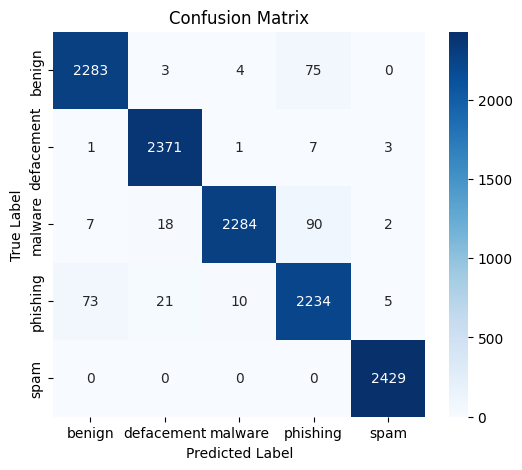

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on Test Set
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


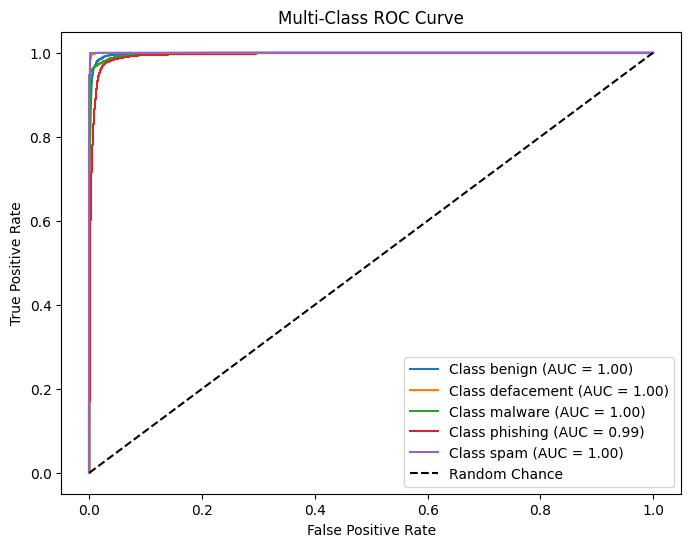

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for ROC-AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(set(y))))
y_pred_bin = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()  # Convert logits to probabilities

# Plot ROC Curve for each class
plt.figure(figsize=(8,6))
for i in range(len(set(y))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()
